In [1]:
import torch
from FisheyeSeg_master.data.CityScape import CityScape
from FisheyeSeg_master.data.FishEyeGenerator import FishEyeGenerator
from torchvision.transforms import ToTensor, ColorJitter, Normalize
from PIL import Image
import random
import numpy as np
from torch.utils.data import DataLoader
from torch import nn
from FisheyeSeg_master.config import DefaultConfig
from FisheyeSeg_master.models.ERFPSPNet import ERFPSPNet
from FisheyeSeg_master.models.SwiftNet import SwiftNet, resnet18
import torch.nn.functional as F
from torch import nn
import math
import segmentation_models_pytorch as smp
from FisheyeSeg_master.test import label2color
import time
from torch.utils.tensorboard import SummaryWriter
import torchvision
import os
import sys
from FisheyeSeg_master.loss import FocalLoss2d, CrossEntropyLoss2d
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import ToTensor, Normalize
import pandas as pd
from torchvision.transforms import ToPILImage


def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

Config = DefaultConfig()
MyDevice = get_default_device()
MyCPU = torch.device('cpu')

d:\Users\admin\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 논문 test+ CityScape 클래스 합치기

In [ ]:
COLOR_MAP = {5:[250, 168, 40], 6:[220, 220, 0], 10:[255,0,0], 11:[0,0,144], 
        0:[127, 65, 128],1:[249, 34, 233], 2:[70, 70, 70], 3:[189, 153, 153], 4:[154, 154, 154],
        7:[106, 142, 34], 8:[70,130,180], 9:[222, 19, 62], 12:[0,0,0]}

# imgs = sorted([os.path.join("./train_source_image/", img) for img in os.listdir("./train_source_image/")])
resnet = resnet18(pretrained=True).to(torch.device('cuda'))
model = SwiftNet(resnet, num_classes=13)
model = model.to(torch.device('cuda'))
checkpoint = torch.load("./checkpoints/addxshift07/ckpt_0.pth")
# print("Load",Config.ckpt_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
model = model.to(torch.device('cuda'))
# print(model)
# 데이터 로드
test_set = CityScape(Config.train_img_dir, transform=None, infer=True)
test_dataloader = DataLoader(test_set, batch_size=Config.batch_size, shuffle=False)

with torch.no_grad():
    model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(MyDevice)
        outputs = model(images)
        # for i in outputs:
        #     print(i)
        # outputs = torch.argmax(outputs, 1).to(MyCPU, dtype=torch.uint8).numpy()
        
        for idx, pred in enumerate(outputs):

            # outputs=outputs[idx]
        #     # print(outputs)
        #     # # .size() 메서드를 사용하여 텐서의 크기 출력
        #     # size = outputs.size()
        #     # print("텐서의 크기 (size()):", size)

        #     # # .shape 속성을 사용하여 텐서의 크기 출력
        #     # shape = outputs[idx].shape
        #     # print("텐서의 크기 (shape):", shape)

            
        #  # outputs = model(images)
        #     # pred = torch.argmax(outputs, 1).to(MyCPU, dtype=torch.uint8).numpy()
        #     # pred = torch.softmax(pred, dim=1).cpu()
        #     # pred = torch.argmax(pred, dim=1).numpy()
        #     pred = pred.cpu().numpy()
        #     # pred=model(pred)
        #     # print(pred)
        #     # pred = pred.astype(np.uint8)
        #     # print(pred)
        #     pred = (pred * 255).astype(np.uint8)
        #     pred = ToTensor()(pred)
        #     print("pred",pred)
        #     pred = pred.to(torch.device('cuda'))
        #     pred.unsqueeze_(0)
            pred = torch.argmax(outputs, 1).to(MyCPU, dtype=torch.uint8)[idx].numpy()
            print(pred)
            # pred = ToTensor()(pred)
            # pred = pred.to(torch.device('cuda'))
            # pred.unsqueeze_(0)
            # pred= pred.cpu()
            pred = np.array(pred) # 다시 수치로 변환    

            pred = Image.fromarray(pred) # 이미지로 변환
            pred = pred.resize((960, 540), Image.NEAREST) # 960 x 540 사이즈로 변환
            pred = np.array(pred) # 다시 수치로 변환    
            shape = pred.shape
 
            # print(pred)
            label = np.zeros((shape[0],shape[1],3), dtype=np.uint8)
            for i in range(shape[0]):
                for j in range(shape[1]):
                    label[i,j] = COLOR_MAP[pred[i,j]]    

            plt.figure(figsize=(15, 10))
            plt.subplot(1, 2, 1)
            plt.imshow(images[idx].cpu().numpy().transpose(1, 2, 0))
            plt.title("Original Image")
            
            plt.subplot(1, 2, 2)
            plt.imshow(label) # 예측 이미지의 cmap을 'jet'으로 설정하여 클래스 구분을 쉽게 함
            plt.title("Predicted Mask")
            
            plt.show()

# with torch.no_grad():
#     model.eval()
#     result = []
#     for images in tqdm(test_dataloader):
#         images = images.float().to(MyDevice)
#         outputs = model(images)
#         outputs = torch.argmax(outputs, 1).to(MyCPU, dtype=torch.uint8).numpy()

#         for idx, pred in enumerate(outputs):
#             pred = pred.astype(np.uint8)
#             # pred = (pred * 255).astype(np.uint8)
#             pred_pil = ToPILImage()(pred)  # NumPy 배열을 PIL 이미지로 변환

#             pred_pil = pred_pil.resize((960, 540), Image.NEAREST)  # 960 x 540 사이즈로 변환
#             pred_pil = np.array(pred_pil)  # 다시 NumPy 배열로 변환

#             label = np.zeros((shape[0], shape[1], 3), dtype=np.uint8)
#             for i in range(shape[0]):
#                 for j in range(shape[1]):
#                     label[i, j] = COLOR_MAP[pred[i, j]]

#             plt.figure(figsize=(15, 10))
#             plt.subplot(1, 2, 1)
#             plt.imshow(images[idx].cpu().numpy().transpose(1, 2, 0))
#             plt.title("Original Image")

#             plt.subplot(1, 2, 2)
#             plt.imshow(label)  # 예측 이미지의 cmap을 'jet'으로 설정하여 클래스 구분을 쉽게 함
#             plt.title("Predicted Mask")

#             plt.show()

In [37]:
# dlrj tn수정수정

  0%|          | 0/549 [00:00<?, ?it/s]

[[[140  82 103]
  [142  81 103]
  [145  81 103]
  ...
  [123 122 120]
  [123 122 120]
  [122 121 119]]

 [[138  81 102]
  [139  81 102]
  [141  80 101]
  ...
  [122 121 119]
  [122 121 119]
  [122 121 119]]

 [[142  83 104]
  [139  81 102]
  [138  80 100]
  ...
  [122 121 119]
  [122 122 119]
  [123 122 119]]

 ...

 [[103 103 103]
  [102 102 102]
  [102 102 102]
  ...
  [226 228 227]
  [227 229 228]
  [227 229 228]]

 [[101 101 101]
  [101 101 101]
  [101 101 101]
  ...
  [223 224 224]
  [224 225 225]
  [225 227 227]]

 [[101 101 101]
  [101 101 101]
  [101 101 101]
  ...
  [218 218 220]
  [221 221 222]
  [222 223 224]]] (1024, 2048, 3)
tensor([[[[-0.7770, -0.7770, -0.8149,  ..., -1.0083, -0.9675, -0.9675],
          [-0.7770, -0.7770, -0.8149,  ..., -1.0083, -0.9675, -0.9675],
          [-0.8143, -0.8143, -0.8541,  ..., -1.0376, -0.9924, -0.9924],
          ...,
          [-0.1726, -0.1726, -0.1959,  ..., -0.2427, -0.2331, -0.2331],
          [-0.1250, -0.1250, -0.1446,  ..., -0.2120

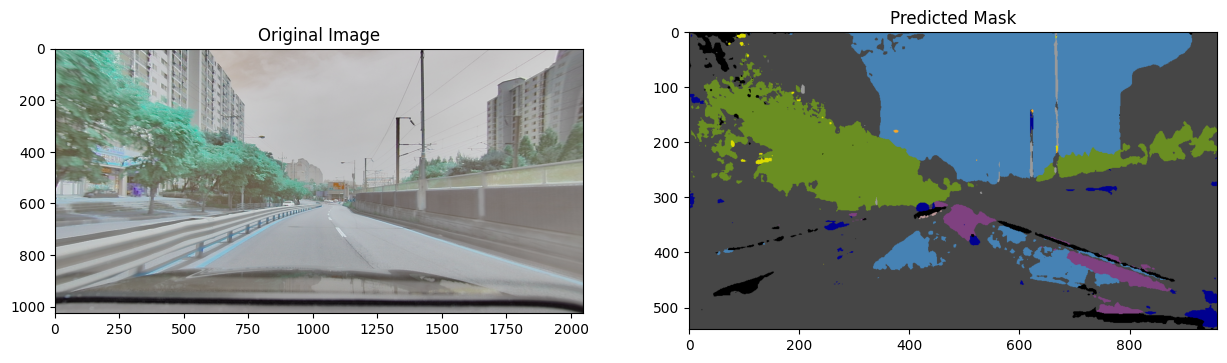

[[[149 163 168]
  [151 166 171]
  [150 165 170]
  ...
  [128 135 138]
  [130 137 141]
  [132 140 144]]

 [[137 152 156]
  [140 155 159]
  [144 158 162]
  ...
  [132 139 144]
  [133 141 146]
  [136 145 150]]

 [[130 144 148]
  [131 145 149]
  [132 146 149]
  ...
  [135 144 149]
  [139 148 154]
  [142 153 158]]

 ...

 [[101  97  90]
  [101  97  90]
  [101  97  90]
  ...
  [237 239 238]
  [237 240 238]
  [237 240 238]]

 [[103  99  92]
  [102  98  91]
  [101  97  90]
  ...
  [234 236 235]
  [235 237 236]
  [236 238 237]]

 [[103  99  92]
  [102  98  91]
  [101  97  90]
  ...
  [231 233 232]
  [232 234 233]
  [233 235 234]]] (1024, 2048, 3)
tensor([[[[-0.3713, -0.3713, -0.3912,  ..., -0.7680, -0.7450, -0.7450],
          [-0.3713, -0.3713, -0.3912,  ..., -0.7680, -0.7450, -0.7450],
          [-0.3745, -0.3745, -0.3915,  ..., -0.7857, -0.7580, -0.7580],
          ...,
          [-0.3150, -0.3150, -0.3430,  ..., -0.1489, -0.1385, -0.1385],
          [-0.2619, -0.2619, -0.2853,  ..., -0.1211

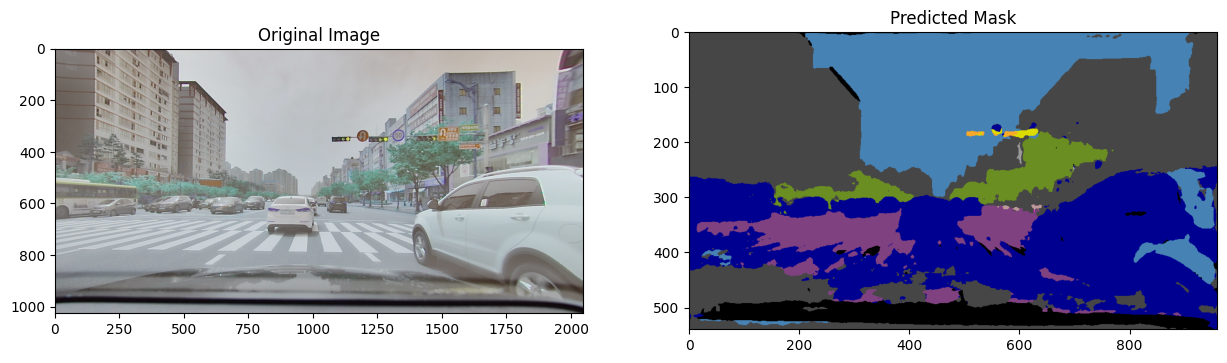

[[[132 135 127]
  [132 136 125]
  [132 138 125]
  ...
  [ 90  88 100]
  [ 90  88 100]
  [ 90  88 100]]

 [[134 137 130]
  [134 137 128]
  [133 137 126]
  ...
  [ 90  88 100]
  [ 90  88 100]
  [ 90  88 100]]

 [[138 141 133]
  [136 139 131]
  [135 138 128]
  ...
  [ 90  88 100]
  [ 90  88 100]
  [ 90  88  99]]

 ...

 [[113 114 112]
  [113 114 112]
  [112 113 111]
  ...
  [215 215 221]
  [218 218 223]
  [221 221 226]]

 [[113 114 112]
  [112 113 111]
  [112 113 111]
  ...
  [200 199 205]
  [205 204 211]
  [211 211 217]]

 [[112 113 111]
  [112 113 111]
  [111 112 110]
  ...
  [185 183 190]
  [190 189 195]
  [196 194 201]]] (1024, 2048, 3)
tensor([[[[-1.0203, -1.0203, -1.0915,  ..., -0.5299, -0.5326, -0.5326],
          [-1.0203, -1.0203, -1.0915,  ..., -0.5299, -0.5326, -0.5326],
          [-1.0656, -1.0656, -1.1392,  ..., -0.5568, -0.5554, -0.5554],
          ...,
          [-0.1103, -0.1103, -0.1290,  ..., -0.2739, -0.2713, -0.2713],
          [-0.0602, -0.0602, -0.0746,  ..., -0.2605

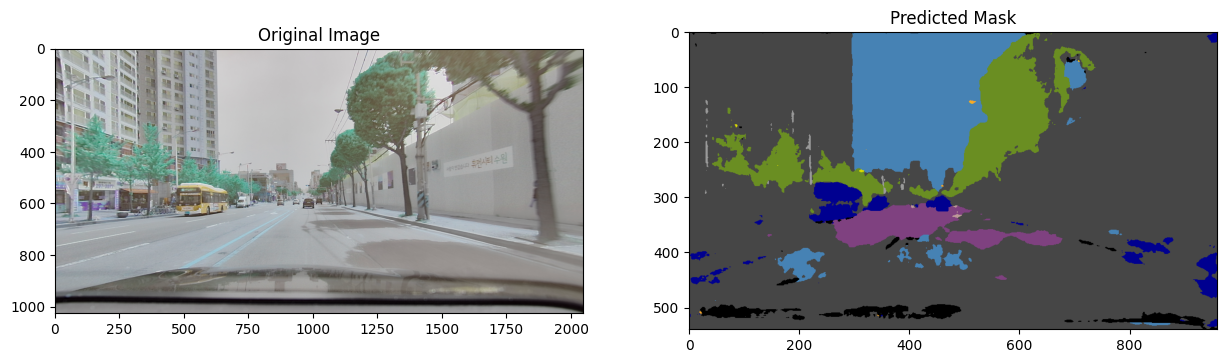

[[[ 58  57  56]
  [ 59  57  56]
  [ 59  57  57]
  ...
  [114  77  51]
  [114  77  51]
  [114  77  51]]

 [[ 59  58  56]
  [ 59  57  56]
  [ 59  57  57]
  ...
  [114  77  51]
  [114  77  51]
  [114  77  51]]

 [[ 59  58  56]
  [ 59  58  56]
  [ 59  57  57]
  ...
  [114  77  51]
  [115  78  52]
  [115  78  52]]

 ...

 [[ 91  91  87]
  [ 91  91  87]
  [ 91  91  87]
  ...
  [230 233 236]
  [230 234 237]
  [231 235 237]]

 [[ 91  91  87]
  [ 91  91  87]
  [ 91  91  87]
  ...
  [226 227 231]
  [228 229 233]
  [229 232 235]]

 [[ 91  91  87]
  [ 91  91  87]
  [ 90  90  86]
  ...
  [222 221 225]
  [224 224 228]
  [225 226 229]]] (1024, 2048, 3)
tensor([[[[-0.5190, -0.5190, -0.5416,  ..., -0.8389, -0.8143, -0.8143],
          [-0.5190, -0.5190, -0.5416,  ..., -0.8389, -0.8143, -0.8143],
          [-0.5506, -0.5506, -0.5761,  ..., -0.8571, -0.8245, -0.8245],
          ...,
          [-0.1779, -0.1779, -0.2161,  ..., -0.3040, -0.2949, -0.2949],
          [-0.1193, -0.1193, -0.1510,  ..., -0.2791

  0%|          | 0/549 [00:13<?, ?it/s]


KeyboardInterrupt: 

In [63]:
COLOR_MAP = {5:[250, 168, 40], 6:[220, 220, 0], 10:[255,0,0], 11:[0,0,144], 
        0:[127, 65, 128],1:[249, 34, 233], 2:[70, 70, 70], 3:[189, 153, 153], 4:[154, 154, 154],
        7:[106, 142, 34], 8:[70,130,180], 9:[222, 19, 62], 12:[0,0,0]}

# imgs = sorted([os.path.join("./train_source_image/", img) for img in os.listdir("./train_source_image/")])
resnet = resnet18(pretrained=True).to(torch.device('cuda'))
model = SwiftNet(resnet, num_classes=13)
model = model.to(torch.device('cuda'))
checkpoint = torch.load("./checkpoints/addxshift07/ckpt_0.pth")
# print("Load",Config.ckpt_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
model = model.to(torch.device('cuda'))
# print(model)
# 데이터 로드
test_set = CityScape(Config.train_img_dir, transform=None, infer=True)
test_dataloader = DataLoader(test_set, batch_size=Config.batch_size, shuffle=False)

with torch.no_grad():
    model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(MyDevice)
        outputs = model(images)
        # for i in outputs:
        #     print(i)
        # outputs = torch.argmax(outputs, 1).to(MyCPU, dtype=torch.uint8).numpy()
        
        for idx, pred in enumerate(outputs):
            # print(images[idx], images[idx].shape)
            # img = images[idx].cpu().numpy().astype(np.uint8)
            img=images[idx].cpu().numpy()
            img = (img * 255).astype(np.uint8)
            img = img.transpose(1, 2, 0)

            # print(img,img.shape )
            img = img.astype(np.uint8)

            # print("astype img ",img)
            img = (img * 255).astype(np.uint8)
            print(img,img.shape )
            img = ToTensor()(img)
            # print("images",images)
            img = img.to(torch.device('cuda'))
            img.unsqueeze_(0)
            # print(img, img.size)
            output2=model(img)
            print(output2)
            # print(output2)
            # outputs=outputs[idx]
        #     # print(outputs)
        #     # # .size() 메서드를 사용하여 텐서의 크기 출력
        #     # size = outputs.size()
        #     # print("텐서의 크기 (size()):", size)

        #     # # .shape 속성을 사용하여 텐서의 크기 출력
        #     # shape = outputs[idx].shape
        #     # print("텐서의 크기 (shape):", shape)

            
        #  # outputs = model(images)
            pred = torch.argmax(output2, 1).to(MyCPU, dtype=torch.uint8)[0].numpy()
            # pred = torch.softmax(outputs, dim=1).cpu()
            # pred = torch.argmax(pred, dim=1)[idx].numpy()
        #     pred = pred.cpu().numpy()
        #     # pred=model(pred)
        #     # print(pred)
        #     # pred = pred.astype(np.uint8)
        #     # print(pred)
        #     pred = (pred * 255).astype(np.uint8)
        #     pred = ToTensor()(pred)
        #     print("pred",pred)
        #     pred = pred.to(torch.device('cuda'))
        #     pred.unsqueeze_(0)
            # pred = torch.argmax(outputs, 1).to(MyCPU, dtype=torch.uint8)[idx].numpy()
            # pred = pred.astype(np.uint8)
            # pred = (pred * 255).astype(np.uint8)

            # print(pred)
            # pred = ToTensor()(pred)
            # pred = pred.to(torch.device('cuda'))
            # pred.unsqueeze_(0)
            # # pred= pred.cpu()
            # pred = np.array(pred) # 다시 수치로 변환    

            pred = Image.fromarray(pred) # 이미지로 변환
            pred = pred.resize((960, 540), Image.NEAREST) # 960 x 540 사이즈로 변환
            pred = np.array(pred) # 다시 수치로 변환    
            shape = pred.shape
 
            # # print(pred)
            label = np.zeros((shape[0],shape[1],3), dtype=np.uint8)
            for i in range(shape[0]):
                for j in range(shape[1]):
                    label[i,j] = COLOR_MAP[pred[i,j]]    
            # print(pred.shape)

            plt.figure(figsize=(15, 10))
            plt.subplot(1, 2, 1)
            plt.imshow(images[idx].cpu().numpy().transpose(1, 2, 0))
            plt.title("Original Image")
            
            plt.subplot(1, 2, 2)
            plt.imshow(label) # 예측 이미지의 cmap을 'jet'으로 설정하여 클래스 구분을 쉽게 함
            plt.title("Predicted Mask")
            
            plt.show()
            
            # class 0 ~ 11에 해당하는 경우에 마스크 형성 / 12(배경)는 제외하고 진행
            for class_id in range(12):
                class_mask = (pred == class_id).astype(np.uint8)
                if np.sum(class_mask) > 0: # 마스크가 존재하는 경우 encode
                    mask_rle = rle_encode(class_mask)
                    result.append(mask_rle)
                else: # 마스크가 존재하지 않는 경우 -1
                    result.append(-1)

# with torch.no_grad():
#     model.eval()
#     result = []
#     for images in tqdm(test_dataloader):
#         images = images.float().to(MyDevice)
#         outputs = model(images)
#         outputs = torch.argmax(outputs, 1).to(MyCPU, dtype=torch.uint8).numpy()

#         for idx, pred in enumerate(outputs):
#             pred = pred.astype(np.uint8)
#             # pred = (pred * 255).astype(np.uint8)
#             pred_pil = ToPILImage()(pred)  # NumPy 배열을 PIL 이미지로 변환

#             pred_pil = pred_pil.resize((960, 540), Image.NEAREST)  # 960 x 540 사이즈로 변환
#             pred_pil = np.array(pred_pil)  # 다시 NumPy 배열로 변환

#             label = np.zeros((shape[0], shape[1], 3), dtype=np.uint8)
#             for i in range(shape[0]):
#                 for j in range(shape[1]):
#                     label[i, j] = COLOR_MAP[pred[i, j]]

#             plt.figure(figsize=(15, 10))
#             plt.subplot(1, 2, 1)
#             plt.imshow(images[idx].cpu().numpy().transpose(1, 2, 0))
#             plt.title("Original Image")

#             plt.subplot(1, 2, 2)
#             plt.imshow(label)  # 예측 이미지의 cmap을 'jet'으로 설정하여 클래스 구분을 쉽게 함
#             plt.title("Predicted Mask")

#             plt.show()